# Model Metrics

* **Last Modified**: 18-03-2022
* **Authors**: Sam Budd, Gonzalo Mateo-García
---

This notebook shows how to compute metrics for a trained model on the *WorldFloods* test dataset. The notebook is divided in 4 steps:

1. Load the config file of the experiment.
1. Create a dataloader for the test dataset.
1. Create the segmentation model and load their weights
1. Run inference on all images in the dataset and compute metrics

**Note**: If you run this notebook in Google Colab change the running environment to use a GPU.

In [ ]:
!pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

In [1]:
import os

## Step 0: Get the data

For this tutorial we need the test dataset and the model trained on the *WorldFloods* dataset. For this tutorial we will get it from our [public Google Drive folder](https://drive.google.com/folderview?id=1dqFYWetX614r49kuVE3CbZwVO6qHvRVH). For other alternatives see [the download *WorldFloods* documentation](./worldfloods_dataset.md).

### Step 0a: mount the Public folder if you are in Google Colab
If you're running this tutorial in Google Colab you need to *‘add a shortcut to your Google Drive’* from the [public Google Drive folder](https://drive.google.com/folderview?id=1dqFYWetX614r49kuVE3CbZwVO6qHvRVH).

![add_shortcut_drive.png](../prep/images/add_shortcut_drive.png)

Then, mount that directory with the following code:

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    assert os.path.exists('/content/drive/My Drive/Public WorldFloods Dataset'), "Add a shortcut to the publice Google Drive folder: https://drive.google.com/drive/u/0/folders/1dqFYWetX614r49kuVE3CbZwVO6qHvRVH"
    google_colab = True
    path_to_dataset_folder = '/content/drive/My Drive/Public WorldFloods Dataset'
    dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
    experiment_name = "WFV1_unet"
    folder_name_model_weights = os.path.join(path_to_dataset_folder, experiment_name)
except ImportError as e:
    print(e)
    print("Setting google colab to false, it will need to install the gdown package!")
    google_colab = False

### Step 0b: If you are in a jupyter notebook, download the data with the gdown package

Download the data using the `gdown` package (if not installed run: `pip install gdown`).

In [ ]:

# Download pre-trained model from Google Drive folder
# Download pre-trained model from Google Drive folder
if not google_colab:
    experiment_name = "WFV1_unet"
    # Download val folder
    path_to_dataset_folder = '.'
    dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
    folder_name_model_weights = os.path.join(path_to_dataset_folder, experiment_name)
    if not os.path.exists(folder_name_model_weights):
        import gdown
        gdown.download_folder(id="1Oup-qVD1U-re3lIQkw7TOKJsdu90blsk", quiet=False, use_cookies=False,
                              output=folder_name_model_weights)

    # Download val folder
    test_folder = os.path.join(dataset_folder, "test")
    if not os.path.exists(test_folder):
        import gdown
        os.makedirs(test_folder, exist_ok=True)
        # https://drive.google.com/drive/folders/1Bp1FXppikOpQrgth2lu5WjpYX7Lb2qOW?usp=sharing
        gdown.download_folder(id="1Bp1FXppikOpQrgth2lu5WjpYX7Lb2qOW", quiet=False, use_cookies=False,
                              output=test_folder)

## Step 1: Get config

In [2]:
from ml4floods.models.config_setup import get_default_config

config_fp = os.path.join(folder_name_model_weights, "config.json")
# config_fp = f"gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/{experiment_name}/config.json"
config = get_default_config(config_fp)
config["model_params"]["max_tile_size"] = 1024

Loaded Config for experiment:  WFV1_unet
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'channel_configuration': 'all',
                       'filter_windows': False,
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 8,
                       'path_to_splits': '/worldfloods/public',
                       'target_folder': 'gt',
                       'test_transformation': {   'normalize': True,
                                                  'num_classes': 3,
                                                  'totensor': True},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {   'normalize': True,
                                                   'num_classes': 3,
                                                   'totensor': True},
                

## Step 2: Load dataloader

In [3]:
from ml4floods.models import dataset_setup

config.data_params.loader_type = 'local'
config.data_params.path_to_splits = dataset_folder # local folder to download the data
config.data_params.bucket_id = ""
config.data_params.train_test_split_file = None

if "filter_windows" in config["data_params"]:
    del config["data_params"]["filter_windows"]


In [4]:
from ml4floods.data.worldfloods.dataset import WorldFloodsDatasetTiled, WorldFloodsDataset
from glob import glob
from ml4floods.models.model_setup import get_channel_configuration_bands

bands_read_s2 = get_channel_configuration_bands(config.data_params.channel_configuration)
test_files = glob(os.path.join(dataset_folder, "test","S2", "*.tif"))

train_transforms, test_transforms = dataset_setup.get_transformations(config.data_params)

test_dataset = WorldFloodsDataset(
            image_files=test_files,
            image_prefix="/S2/",
            gt_prefix="/gt/",
            bands=bands_read_s2,
            transforms=test_transforms,
            lock_read=False
        )
print(f"There are {len(test_dataset)} images in the dataset")

Using local dataset for this run
Skip download train
Downloaded (0/11) 2_PROD/2_Mart/worldfloods_v1_0/test/S2/EMSR286_08ITUANGONORTH_DEL_MONIT02_v1_observed_event_a.tif
Downloaded (1/11) 2_PROD/2_Mart/worldfloods_v1_0/test/S2/EMSR286_09ITUANGOSOUTH_DEL_MONIT02_v1_observed_event_a.tif
Downloaded (2/11) 2_PROD/2_Mart/worldfloods_v1_0/test/S2/EMSR333_01RATTALORO_DEL_MONIT01_v1_observed_event_a.tif
Downloaded (3/11) 2_PROD/2_Mart/worldfloods_v1_0/test/S2/EMSR333_02PORTOPALO_DEL_MONIT01_v1_observed_event_a.tif
Downloaded (4/11) 2_PROD/2_Mart/worldfloods_v1_0/test/S2/EMSR333_13TORRECOLONNASPERONE_DEL_MONIT01_v2_observed_event_a.tif
Downloaded (5/11) 2_PROD/2_Mart/worldfloods_v1_0/test/S2/EMSR342_06NORTHNORMANTON_DEL_v1_observed_event_a.tif
Downloaded (6/11) 2_PROD/2_Mart/worldfloods_v1_0/test/S2/EMSR342_07SOUTHNORMANTON_DEL_MONIT03_v2_observed_event_a.tif
Downloaded (7/11) 2_PROD/2_Mart/worldfloods_v1_0/test/S2/EMSR347_06MWANZA_DEL_v1_observed_event_a.tif
Downloaded (8/11) 2_PROD/2_Mart/worl

In [5]:
from torch.utils.data import DataLoader
dl = DataLoader(test_dataset, batch_size=1,
                num_workers=1, shuffle=False)
# dl = data_module.val_dataloader()

## Step 3: Load a trained model

In [6]:
from ml4floods.models.model_setup import get_model

model_folder = os.path.dirname(folder_name_model_weights)
if model_folder == "":
    model_folder = "."
    
config["model_params"]['model_folder'] = model_folder
config["model_params"]['test'] = True
model = get_model(config.model_params, experiment_name)

model.eval()
model.to("cuda")

WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

## Step 4: Run inference on all the images in the test dataset

In [7]:
from ml4floods.models.model_setup import get_model_inference_function

if config["model_params"].get("model_version","v1") == "v2":
    inf_func = get_model_inference_function(model, config, apply_normalization=False, 
                                        activation="sigmoid")
    print("v2 inference function converted to v1")
    def inference_function(x):
        dual_head_output = inf_func(x)
        B, C, H, W = dual_head_output.shape
        out = torch.zeros((B, 3, H, W),dtype=dual_head_output.dtype)
        out[:, 2] = dual_head_output[:, 0]
        out[:, 1] = (1 - dual_head_output[:, 0]) * dual_head_output[:, 1]
        out[:, 0] = (1 - dual_head_output[:, 0]) * (1 - dual_head_output[:, 1])
        return out
else:
    inference_function = get_model_inference_function(model, config, apply_normalization=False, 
                                                      activation="softmax")

Getting model inference function
Max tile size: 256


100%|██████████| 11/11 [02:17<00:00, 12.50s/it]


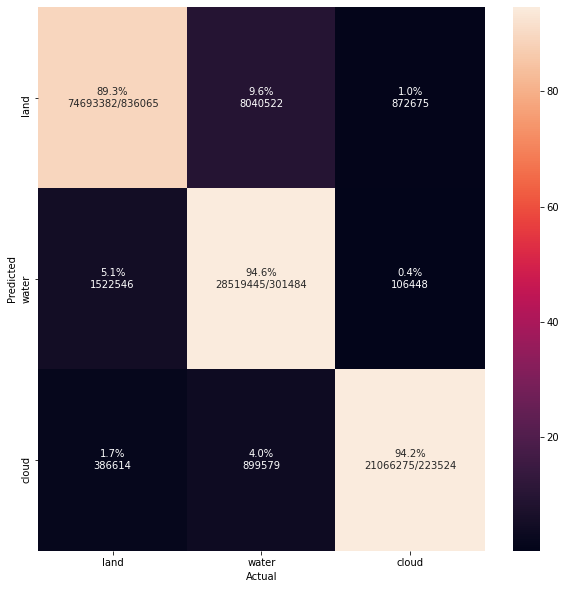

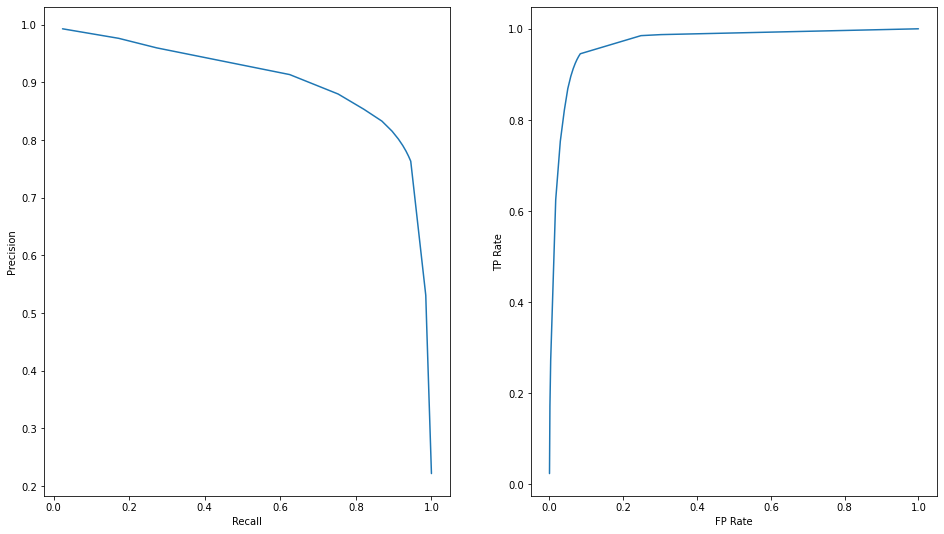

Per Class IOU {
    "cloud": 0.9029077785566316,
    "land": 0.8734460214394203,
    "water": 0.7296114155197847
}


In [8]:
import torch
import numpy as np
import pandas as pd
from ml4floods.models.utils import metrics

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    mask_clouds=False,
    convert_targets=False,
    thresholds_water=thresholds_water, 
    plot=False)

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)

## Step 5: Compute the metrics for each flood in the test dataset

In [9]:
CODES_LOC = {"EMSR333": "EMSR333 (Italy)",
             "EMSR9284": "EMSR284 (Finland)",
             "EMSR347": "EMSR347 (Malawi)",
             "EMSR286": "EMSR286 (Colombia)",
             "EMSR342": "EMSR342 (Australia)"
            }

if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in ["land", "water", "cloud"]]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in ["land", "water", "cloud"]]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code["code"] = join_data_per_code["code"].apply(lambda x: CODES_LOC.get(x,x))
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 89.13838818450972, 'Recall_water': 91.76496994702889, 'Recall_cloud': 97.21174578522877, 'IoU_land': 87.7264665724063, 'IoU_water': 74.14875561083508, 'IoU_cloud': 70.01686774881253}


,Recall_land,Recall_water,Recall_cloud,IoU_land,IoU_water,IoU_cloud
code,,,,,,
EMSR286 (Colombia),95.778702,96.101370,98.995128,94.452269,85.104708,96.259330
EMSR333 (Italy),90.776235,86.642480,99.119989,89.956551,59.949436,73.404743
EMSR342 (Australia),69.510674,97.022392,92.000729,67.419744,72.314018,89.287511
EMSR347 (Malawi),98.848191,81.740996,95.942883,96.865007,76.443802,91.132753
EMSR284 (Finland),90.778140,97.317612,100.000000,89.938762,76.931815,0.000002
